In [32]:
import h5py
import matplotlib.pyplot as plt
import os
from transformers import BridgeTowerModel, BridgeTowerProcessor, BridgeTowerImageProcessor
import torch

# Part 2: Feature Extraction
Now that we've been introduced to BridgeTower and how it can be used to extract feature vectors from movies, let's apply this to the original dataset. The stimuli used in the original experiments were movie clips (https://gin.g-node.org/gallantlab/shortclips/src/master/stimuli) and transcripts of stories (https://openneuro.org/datasets/ds003020). We will do forward passess of each into our model to extract feature vectors.

### 1 Get Movie Stimuli
There are 12 training movies (0-11) and 1 test movie. We should end this first part with 13 datasets each containing 270-300 feature vectors with 768 dimensions each (8100-9000 images presented at 15 frames per second, average over every 2 seconds).

Our movie stimuli is in hdf5 format such that each file in `stimuli` contains:
    stimuli: array of shape (n_images, 512, 512, 3)
        Each training run contains 9000 images total.
        The test run contains 8100 images total.

In [33]:
def load_hdf5_array(file_name, key=None, slice=slice(0, None)):
    """Function to load data from an hdf file.

    Parameters
    ----------
    file_name: string
        hdf5 file name.
    key: string
        Key name to load. If not provided, all keys will be loaded.
    slice: slice, or tuple of slices
        Load only a slice of the hdf5 array. It will load `array[slice]`.
        Use a tuple of slices to get a slice in multiple dimensions.

    Returns
    -------
    result : array or dictionary
        Array, or dictionary of arrays (if `key` is None).
    """
    with h5py.File(file_name, mode='r') as hf:
        if key is None:
            data = dict()
            for k in hf.keys():
                data[k] = hf[k][slice]
            return data
        else:
            return hf[key][slice]

In [41]:
test = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\test.hdf', key='stimuli')


In [ ]:
train_00 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_00.hdf', key='stimuli')
train_01 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_01.hdf', key='stimuli')
train_02 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_02.hdf', key='stimuli')
train_03 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_03.hdf', key='stimuli')
train_04 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_04.hdf', key='stimuli')
train_05 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_05.hdf', key='stimuli')
train_06 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_06.hdf', key='stimuli')
train_07 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_07.hdf', key='stimuli')
train_08 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_08.hdf', key='stimuli')
train_09 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_09.hdf', key='stimuli')
train_10 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_10.hdf', key='stimuli')
train_11 = load_hdf5_array('bridgetower\\data\\shortclips\\stimuli\\train_11.hdf', key='stimuli')

(8100, 512, 512, 3)


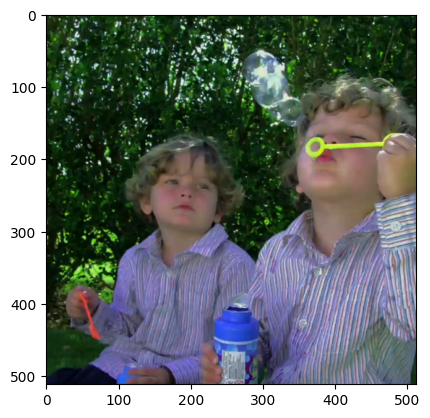

In [42]:
print(test.shape)
plt.imshow(test[0])

#### 1.1 Create functions
Let's create some quick functions to streamline the process of extracting features from the video

In [43]:
# set-up
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.cross_modal_image_pooler.register_forward_hook(get_features('layer_8'))

In [44]:
processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")

In [45]:
test.shape[0]

8100

In [46]:
processor(test[0], "", return_tensors="pt")

{'input_ids': tensor([[0, 2]]), 'attention_mask': tensor([[1, 1]]), 'pixel_values': tensor([[[[-1.2667, -1.1937, -1.2229,  ..., -1.4565, -1.4273, -1.4419],
          [-1.2521, -1.2229, -0.9310,  ..., -0.9748, -1.3835, -1.5733],
          [-1.2667, -1.2667, -0.6974,  ..., -1.1499, -1.4273, -1.5733],
          ...,
          [-1.5441, -1.5295, -1.5295,  ..., -1.5733, -1.5733, -1.6171],
          [-1.5587, -1.5295, -1.5587,  ..., -1.5441, -1.5733, -1.6317],
          [-1.5879, -1.5733, -1.5879,  ..., -1.4857, -1.5733, -1.6171]],

         [[-0.9717, -0.9567, -0.9417,  ..., -0.9267, -0.9117, -0.9117],
          [-0.9267, -0.9867, -0.6265,  ..., -0.3714, -0.8666, -1.0617],
          [-0.9267, -1.0017, -0.3714,  ..., -0.6265, -0.9417, -1.0918],
          ...,
          [-1.4219, -1.4369, -1.4369,  ..., -1.1368, -1.0467, -1.0017],
          [-1.4369, -1.4369, -1.4669,  ..., -1.1068, -1.0467, -1.0317],
          [-1.4669, -1.4820, -1.5120,  ..., -1.0617, -1.0617, -1.0617]],

         [[-1.1247

In [55]:
def get_feature_vecs(stim_data, n=30):
    # create overall data structure for average feature vectors
    # a dictionary with layer names as keys and a list of vectors as it values
    data = {}

    # a dictionary to store vectors for n consecutive trials
    avg_data = {}

    # loop through all inputs
    for i, image in enumerate(stim_data):

        model_input = processor(image, "", return_tensors="pt")
        
        preds = model(**model_input)

        for name, tensor in features.items():
            if name not in avg_data:
                avg_data[name] = []
            avg_data[name].append(tensor)
        
        # check if average should be stored
        if (i + 1) % n == 0:
            for name, tensors in avg_data.items():
                first_size = tensors[0].size()

                if all(tensor.size() == first_size for tensor in tensors):
                    avg_feature = torch.mean(torch.stack(tensors), dim=0)
                else:
                    # Find problem dimension
                    for dim in range(tensors[0].dim()):
                        first_dim = tensors[0].size(dim)

                        if not all(tensor.size(dim) == first_dim for tensor in tensors):
                            # Specify place to pad
                            p_dim = (tensors[0].dim()*2) - (dim + 2)
                            # print(p_dim)
                            max_size = max(tensor.size(dim) for tensor in tensors)
                            padded_tensors = []

                            for tensor in tensors:
                                pad_list = [0] * ((2*tensor[0].dim()) - 1 )  # Make a list with length of 2*dimensions - 1 to insert pad later
                                pad_list.insert(p_dim, max_size - tensor.size(dim))
                                # print(tuple(pad_list))
                                padded_tensor = pad(tensor, tuple(pad_list))
                                padded_tensors.append(padded_tensor)

                    avg_feature = torch.mean(torch.stack(padded_tensors), dim=0)

                if name not in data:
                    data[name] = []
                data[name].append(avg_feature)

            avg_data = {}
            print(str(round((((i + 1) / n) / (stim_data.shape[0]/30)) * 100,2)) + "%" + " complete")
    return data

In [56]:
test_data = get_feature_vecs(test)

0.37% complete
0.74% complete
1.11% complete
1.48% complete
1.85% complete
2.22% complete
2.59% complete
2.96% complete
3.33% complete
3.7% complete
4.07% complete
4.44% complete
4.81% complete
5.19% complete
5.56% complete
5.93% complete
6.3% complete
6.67% complete
7.04% complete
7.41% complete
7.78% complete
8.15% complete
8.52% complete
8.89% complete
9.26% complete
9.63% complete
10.0% complete
10.37% complete
10.74% complete
11.11% complete
11.48% complete
11.85% complete
12.22% complete
12.59% complete
12.96% complete
13.33% complete
13.7% complete
14.07% complete
14.44% complete
14.81% complete
15.19% complete
15.56% complete
15.93% complete
16.3% complete
16.67% complete
17.04% complete
17.41% complete
17.78% complete
18.15% complete
18.52% complete
18.89% complete
19.26% complete
19.63% complete
20.0% complete
20.37% complete
20.74% complete
21.11% complete
21.48% complete
21.85% complete
22.22% complete
22.59% complete
22.96% complete
